In [1]:
# en = args.encoder_layers
# de= args.decoder_layers
# random.seed(3000)
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
from neurite_sandbox.tf.models import labels_to_labels
import nibabel as nib
import tqdm
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
from utils import *
import pathlib
import surfa as sf


mgh = pathlib.Path('fetus_brain_label_map_ring')
files = list(mgh.glob('*.nii.gz'))

# label_maps = [np.uint8(sf.load_volume(str(file_path)).resize([1,1,1],method='nearest').data) for file_path in mgh_files]

label_maps = [np.uint8(f.dataobj) for f in map(nib.load, files)]


# label_maps = crop_img(label_maps,dimx,dimy,dimz)
labels = np.unique(label_maps)
in_shape = label_maps[0].shape


labels = np.unique(label_maps)
num_labels=8
labels_in = range(max(labels) + num_labels + 1)



2024-01-24 22:03:12.160574: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-24 22:03:12.212715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2


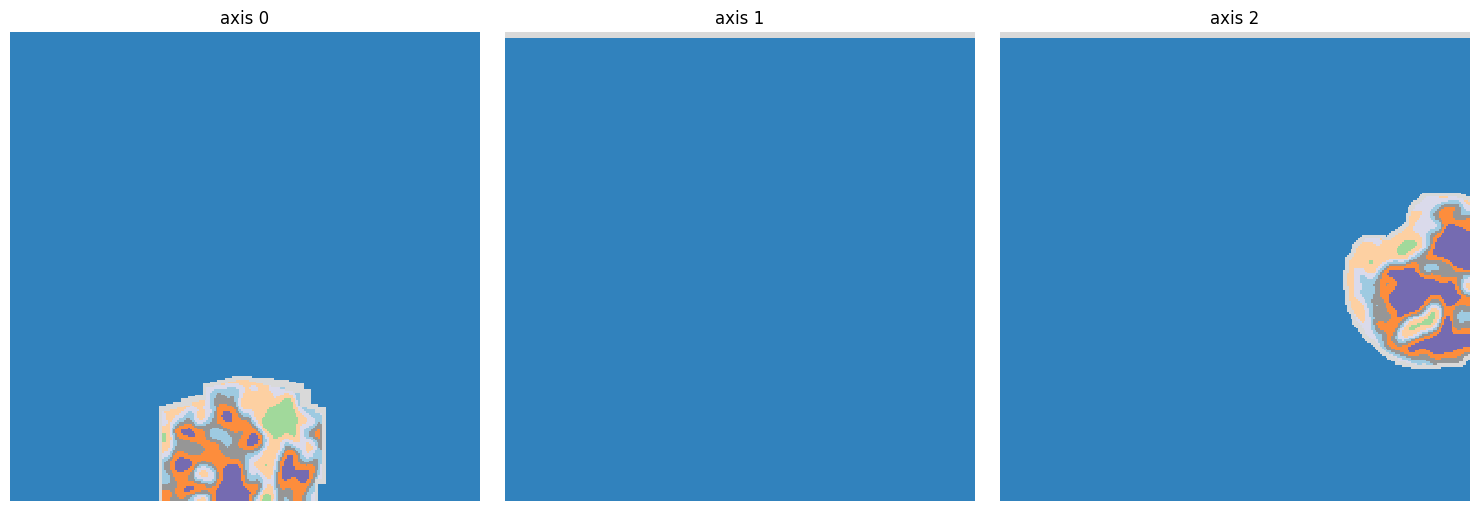

In [2]:
label_maps = add_ring(label_maps)
ne.plot.volume3D(label_maps[0],cmaps=['tab20c'])

10 8


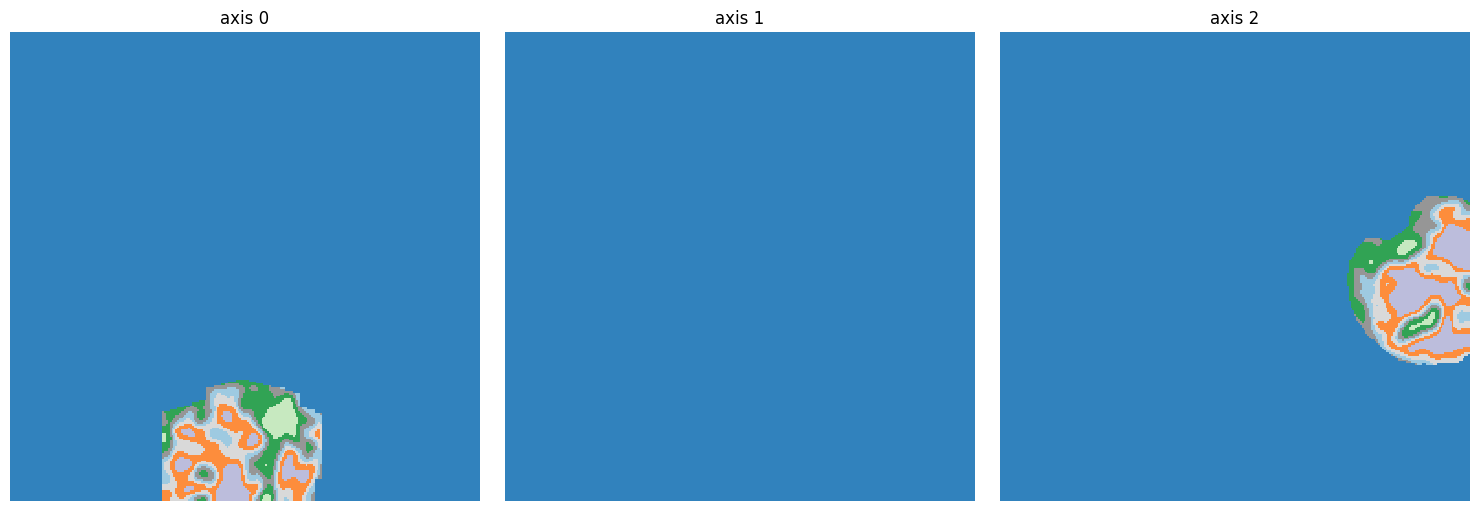

In [7]:
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
def get_brain(a):
    a_copy = np.copy(a)
    for i in range(len(a)):
        a_copy[i][a[i] >7 ] = 0
    return a_copy




import numpy as np

import numpy as np

def get_fov3(a):
    a_copy = np.copy(a)
    
    for i in range(len(a)):
        b = a_copy[i]
        m = (b >= 1) & (b < 8)
        b[m]=0
        d = np.random.randint(0, 3)
        s = np.random.randint(0, b.shape[2 - d] - m.shape[2 - d] + 1)
        start = max(0, s)
        end = min(b.shape[d], s + m.shape[d])
        mask_shifted = np.zeros_like(b, dtype=bool)
        mask_shifted[start:end] = m[start-s:end-s]
        b[m] = a_copy[i][mask_shifted]
        a_copy[i] = b
        
    return a_copy
    
import numpy as np
import numpy as np

def get_fov2(a, max_shift=60):
    a_copy = np.copy(a)
    
    for i in range(len(a)):
        b = a_copy[i]
        m = (b >= 1) & (b < 8)
        m = binary_dilation((m > 0), structure=np.ones((5, 5, 5)))

        max_sum = 0
        best_shift = 0
        best_direction = 0

        for d in range(3):
            for shift in range(-max_shift, max_shift + 1):
                shifted_m = np.roll(m, shift, axis=d)
                current_sum = np.sum(b[shifted_m])

                if current_sum > max_sum:
                    max_sum = current_sum
                    best_shift = shift
                    best_direction = d

        shifted_m = np.roll(m, best_shift, axis=best_direction)
        b[m] = a_copy[i][shifted_m]
        
        a_copy[i] = b

    return a_copy




def get_fov(a):
    a_copy = np.copy(a)

    for i in range(len(a)):
        a_copy[i][a[i] <8 ] = 0
    return a_copy

def generator3D_noshape(label_maps):
    rand = np.random.default_rng()
    label_maps = np.asarray(label_maps)
    
    while True:
        fg = rand.choice(label_maps)
        yield fg[None, ..., None]



def generator(label_maps, shapes):
    rand = np.random.default_rng()
    label_maps = np.asarray(label_maps)
    shapes = np.asarray(shapes)
    
    while True:
        fg = rand.choice(label_maps)
        bg = rand.choice(shapes)
        out = fg + bg * (fg == 0)
        yield out[None, ..., None]

def generator_bg3D(label_maps):
    rand = np.random.default_rng()
    
    for i in range(len(label_maps)):
        label_maps[i][label_maps[i] <8 ] = 0
    
    label_maps = np.asarray(label_maps)

    while True:
        fg = rand.choice(label_maps)
        yield fg[None, ..., None]
        
def generator_brain3D(label_maps):
    rand = np.random.default_rng()
    
    for i in range(len(label_maps)):
        label_maps[i][label_maps[i] > 7] = 0
    
    label_maps = np.asarray(label_maps)

    while True:
        fg = rand.choice(label_maps)
        yield fg[None, ..., None]


def generator3D(label_maps, shapes, zero_background):
    rand = np.random.default_rng()
    label_maps = np.asarray(label_maps)
    shapes = np.asarray(shapes)
    
    while True:
        fg = rand.choice(label_maps)
        
        # Determine whether to add background shapes
        if rand.random() > zero_background:
            bg = rand.choice(shapes)
            fg = fg + bg * (fg == 0)
        
        yield fg[None, ..., None]

def generatorFOV(brain_maps, fov_maps):
    rand = np.random.default_rng()
    brain_maps = np.asarray(brain_maps)
    fov_maps = np.asarray(fov_maps)
    
    while True:
        idx = rand.choice(len(brain_maps))
        brain_label = brain_maps[idx]
        body_label = fov_maps[idx]
        yield brain_label[None, ..., None], body_label[None, ..., None]

# Show.
print(len(label_maps),np.max(label_maps[0]))
# gen = generator3D(label_maps)
num_row = 2
per_row = 8

brain_maps = get_brain(label_maps)
# fov_maps = get_fov2(label_maps)

ne.plot.volume3D(brain_maps[0],cmaps=['tab20c'])

In [8]:
num_shapes = 5
shapes = [draw_shapes(in_shape, num_labels) for _ in range(num_shapes)]
shapes = map(np.squeeze, shapes)
shapes = map(np.uint8, shapes)
shapes = [f + max(labels) + 1 for f in shapes]


In [ ]:
gen = generator3D(brain_maps, shapes, 0.2)

sample_label_map=next(gen)
ne.plot.volume3D(sample_label_map)
nib.save(nib.Nifti1Image(np.squeeze(sample_label_map, axis=(0, -1)).astype(np.int32), np.eye(4)), f"output/sample_mgh.nii.gz")


In [3]:
sample_label_map.shape

NameError: name 'sample_label_map' is not defined

In [22]:
np.min(shapes[3])

9

In [18]:
labels_in

range(0, 17)

In [23]:
max(labels)

8